# Toy Examples

_Note_: If you want to ensure your figure aesthetics are the same, either manually configure the `rc` variable in the first cell or place these lines in your `~/.config/matplotlib/matplotlibrc` file:

    lines.linewidth: 2
    lines.markeredgecolor: k
    lines.markeredgewidth: 1.3
    boxplot.whiskers: 1.5
    boxplot.patchartist: True
    boxplot.showmeans: True
    boxplot.meanline: False
    boxplot.boxprops.linewidth: 1.5
    boxplot.whiskerprops.linewidth: 1.5
    boxplot.medianprops.linewidth: 1.5
    boxplot.medianprops.color: None
    boxplot.meanprops.marker: ^
    boxplot.meanprops.markerfacecolor: w
    boxplot.meanprops.markeredgecolor: k
    axes.grid: True
    axes.linewidth: 1.5
    xtick.bottom: True
    xtick.labelbottom: True
    xtick.major.width: 1.5
    xtick.minor.width: 1 
    ytick.left: True
    ytick.labelleft: True
    ytick.major.width: 1.5
    ytick.minor.width: 1 
    grid.linestyle: --
    hist.bins: auto  
    savefig.bbox: tight

In [1]:
from typing import Optional

from fastcluster import complete as max_linkage
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.cluster.hierarchy import fcluster
from scipy.integrate import trapezoid

rc = mpl.rc_params_from_file(mpl.matplotlib_fname(), use_default_template=False)
sns.set_theme(style="white", rc=rc)

## Distance distributions

In [3]:
def calc_rogi(D: np.ndarray, y: np.ndarray, min_dt: float = 0.01):
    Z = max_linkage(D)
    thresholds_all = Z[:, 2]
    
    thresholds = []
    t_prev = -1
    for t in thresholds_all:
        if t < t_prev + min_dt:
            continue

        thresholds.append(t)
        t_prev = t

    n_clusters = []
    cg_sds = []
    for t in thresholds:
        cluster_ids = fcluster(Z, t, "distance")
        clusters = set(cluster_ids)

        y_cg = np.copy(y)
        for i in clusters:
            mask = cluster_ids == i
            y_cg[mask] = y[mask].mean()
            
        n_clusters.append(len(clusters))
        cg_sds.append(y_cg.std())
    
    thresholds = np.array([0, *thresholds, 1])
    n_clusters = np.array([len(y), *n_clusters, 1])
    cg_sds = np.array([y.std(), *cg_sds, 0])

    disp_loss = 2 * (cg_sds[0] - cg_sds)

    log_cr = 1 - np.log(n_clusters) / np.log(n_clusters[0])
    cr = 1 - n_clusters / n_clusters[0]

    return disp_loss, thresholds, log_cr


def plot_auc(x, y, label, ax: plt.Axes = None):
    ax = ax or plt.gca()

    lines = ax.plot(x, y, '-', label=label, alpha=0.9)
    pc = ax.fill_between(x, 0, y, alpha=0.1, label='_x')
    
    return lines[0], trapezoid(y, x)

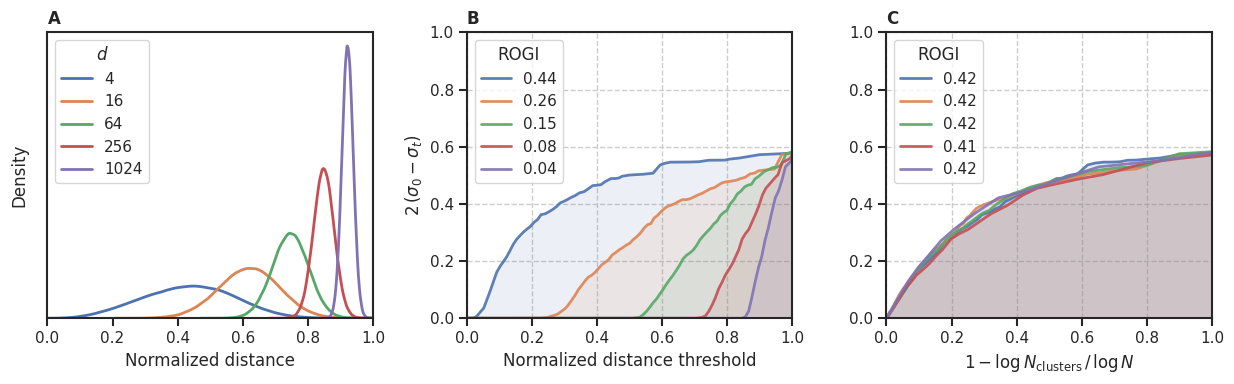

In [6]:
NCOLS = 3
DIMS = 4 ** np.arange(1, 6)
RG = np.random.default_rng(24)
N = 1000

fig, axs = plt.subplots(1, NCOLS, figsize=(NCOLS * 4 + 0.5, 4))

handles_aucs_1 = []
handles_aucs_2 = []
for d in DIMS:
    y = RG.uniform(size=N)
    X = RG.uniform(size=(N, d))
    D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
    D = D[np.triu_indices(N, 1)]
    D /= D.max()
    
    sns.kdeplot(x=D, ax=axs[0], label=d, lw=2)

    disp_loss, thresholds, n_clusters = calc_rogi(D, y, 0.01)

    handle, auc = plot_auc(thresholds, disp_loss, d, axs[1])
    handles_aucs_1.append((handle, auc))

    handle, auc = plot_auc(n_clusters, disp_loss, d, axs[2])
    handles_aucs_2.append((handle, auc))

handles_1, aucs_1 = zip(*handles_aucs_1)
labels_1 = [f"{auc:0.2f}" for auc in aucs_1]

handles_2, aucs_2 = zip(*handles_aucs_2)
labels_2 = [f"{auc:0.2f}" for auc in aucs_2]

axs[0].set_title("A", fontweight="bold", loc="left")
axs[0].legend(title=r"$d$")
axs[0].set_yticks([])
axs[0].set_xlim(0, 1)
axs[0].grid(False)
axs[0].set_xlabel("Normalized distance")
axs[0].set_ylabel("Density", labelpad=8)

axs[1].set_title("B", fontweight="bold", loc="left")
axs[1].legend(handles_1, labels_1, title="ROGI", loc='upper left')
axs[1].set_xlabel("Normalized distance threshold")
axs[1].set_ylabel(r"$2\,(\sigma_0-\sigma_t)$")
axs[1].sharey(axs[2])

axs[2].set_title("C", fontweight="bold", loc="left")
axs[2].legend(handles_2, labels_2, title="ROGI", loc='upper left')
axs[2].set_xlabel(r"$1 - \log N_{\mathrm{clusters}}\,/\,\log N$")

for ax in axs[1:]:
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)

fig.tight_layout()

In [5]:
fig.savefig("../results/figures/toy/dists+rogi.pdf", bbox_inches="tight")

## Figure 1

In [2]:
rg = np.random.default_rng(118999881999119725300)

X = rg.uniform(size=(150, 2))
y = rg.uniform(size=len(X))

D = np.sqrt(np.sum(np.square(X[None, :, :] - X[:, None, :]), -1))
D = D[np.triu_indices(D.shape[0], 1)]
D /= D.max()
Z = max_linkage(D)

THRESHOLDS = np.linspace(0, 1.00, 5)
cbar_kwargs = dict(cmap='plasma', vmin=y.min(), vmax=y.max())

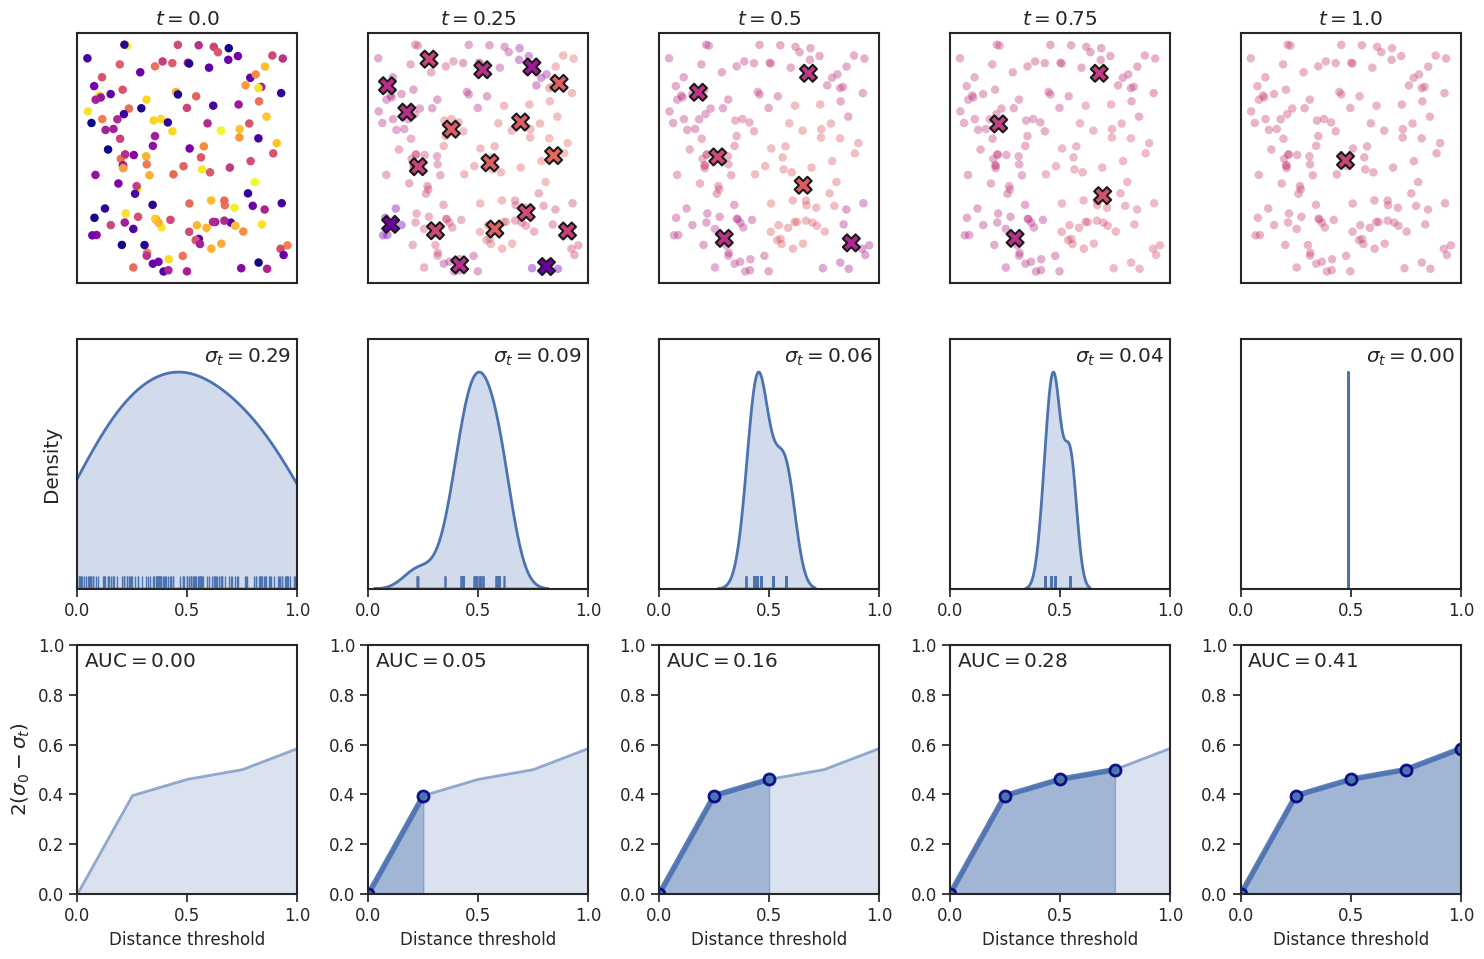

In [13]:
NROWS = 3
ncols = len(THRESHOLDS)
fig, axs = plt.subplots(NROWS, ncols, figsize=(3 * ncols, 3.25 * NROWS))

sds = []
for j in range(ncols):
    t = THRESHOLDS[j]

    cluster_ids = fcluster(Z, t, "distance")
    clusters = set(cluster_ids)

    y_cg = np.copy(y)
    X_centroids = []
    y_centroids = []
    for i in clusters:
        mask = cluster_ids == i
        y_ = y[mask].mean()
        x_ = X[mask].mean(0)

        X_centroids.append(x_)
        y_centroids.append(y_)
        y_cg[mask] = y_
    sds.append(y_cg.std())
    X_centroids = np.array(X_centroids)

    # SCATTER PLOTS
    ax = axs[0, j]
    if j == 0:
        ax.scatter(X[:, 0], X[:, 1], 150, y_cg, '.', edgecolor='None', **cbar_kwargs)
    else:
        ax.scatter(X[:, 0], X[:, 1], 150, y_cg, '.', edgecolor='None', **cbar_kwargs, alpha=0.4)
        ax.scatter(
            X_centroids[:, 0], X_centroids[:, 1], 150, y_centroids, 'X',
            **cbar_kwargs, edgecolor='k', linewidth=1.5
        )

    ax.set_title(rf"$t={t}$", fontsize="large")
    ax.set_yticks([])
    ax.set_xticks([])

    # DISTRIBUTION PLOTS
    ax = axs[1, j]
    sns.kdeplot(x=y_cg, fill=True, bw_method=0.7, lw=2, ax=ax)
    sns.rugplot(x=y_cg, height=0.05, ax=ax)
    ax.text(
        1 - 0.03, 1 - 0.03, rf"$\sigma_t={sds[j]:0.2f}$",
        ha="right", va="top", fontsize='large', transform=ax.transAxes
    )
    ax.set_yticks([])
    ax.set_xticks([0, 0.5, 1.])
    ax.grid(False)
    ax.set_xlim(0, 1)
    ax.tick_params(axis='x', which='major', direction='out', bottom=True, labelsize='medium')


# AUC PLOTS
sds = 2 * np.array(sds)
y_cg = sds[0] - sds
for j in range(ncols):
    ax: plt.Axes = axs[2, j]
    ax.plot(THRESHOLDS, y_cg, '-', lw=2, alpha=0.6)
    ax.fill_between(THRESHOLDS, 0, y_cg, alpha=0.2)

    auc = trapezoid(y_cg[:j + 1], THRESHOLDS[:j + 1])
    ax.text(
        0.03, 1 - 0.03, rf"$\mathrm{{AUC}}={auc:0.2f}$",
        ha="left", va="top", fontsize='large', transform=ax.transAxes
    )
    
    ax.set_xticks([0, 0.5, 1.])
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Distance threshold")
    ax.tick_params(
        axis='both', which='major', direction='out', bottom=True, left=True, labelsize='medium'
    )
    ax.grid(False)

for j in range(1, ncols):
    ax: plt.Axes = axs[2, j]
    ax.plot(THRESHOLDS[:j + 1], y_cg[:j + 1], 'bo-', lw=4, mec="navy", mew=2, ms=8, alpha=0.9)
    ax.fill_between(THRESHOLDS[:j + 1], 0, y_cg[:j + 1], color='b', alpha=0.4)
    

for j in range(1, ncols):
    axs[1, j-1].sharex(axs[1, j])
    axs[1, j].set_ylabel(None)

    axs[2, j-1].sharex(axs[2, j])
    axs[2, j-1].sharey(axs[2, j])
    axs[2, j].set_ylabel(None)

axs[1, 0].set_ylabel("Density", fontsize='large', labelpad=12)
axs[2, 0].set_ylabel(f"$2(\sigma_0 - \sigma_t)$", fontsize='large')
fig.tight_layout()

In [14]:
fig.savefig("../results/figures/toy/example.pdf", bbox_inches="tight")

## Figure 2 recreation

In [ ]:
def linear(X: np.ndarray):
    return np.prod(X, axis=1)


def radial(X: np.ndarray):
    return np.sum(np.square(X - X.mean(0)), -1)


def checkerboard(
    X: np.ndarray, anchors: np.ndarray, radius: Optional[float] = None, square: bool = True
):
    D = X[:, None] - anchors[None, :]   # n x c x d
    d = np.sqrt(np.sum(np.square(D), -1))   # n x c

    if radius is None:
        y = d.min(-1)
    elif square:
        y = (np.abs(D) < radius).all(-1).any(-1)
    else:
        y = (d < radius).any(-1)

    return 1.0 * y


def jagged(X: np.ndarray):
    D = X[:, None] - X[None, :]
    idxs = D.argmin(-1)

[]

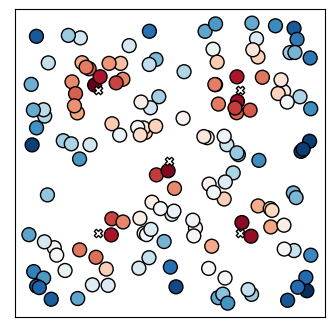

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

xi, yi = np.linspace(0, 1, 5)[1:-1], np.linspace(0, 1, 5)[1:-1]
anchors = np.array(np.meshgrid(xi, yi)).T.reshape(-1, 2)[::2]
# anchors = np.array([[0.5, 0.5]])
y = checkerboard(X, anchors)

ax.scatter(X[:, 0], X[:, 1], 100, y, 'o', "RdBu", edgecolors='k')
ax.scatter(anchors[:, 0], anchors[:, 1], marker='X', edgecolors='k', c='w')
ax.set_yticks([])
ax.set_xticks([])